In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [20]:
def rrc_filter(beta, sps, num_taps):
    """Genera un filtro de Coseno Elevado Raíz (RRC)."""
    t = np.arange(-num_taps // 2, num_taps // 2 + 1) / sps
    pi_t = np.pi * t
    four_beta_t = 4 * beta * t

    with np.errstate(divide="ignore", invalid="ignore"):
        numerator = np.sin(pi_t * (1 - beta)) + 4 * beta * t * np.cos(pi_t * (1 + beta))
        denominator = pi_t * (1 - (four_beta_t) ** 2)
        h = numerator / denominator

    # Manejo de t = 0
    h[np.isnan(h)] = 1.0 - beta + (4 * beta / np.pi)
    # Manejo de t = ±1/(4β)
    t_special = np.abs(t) == (1 / (4 * beta))
    h[t_special] = (beta / np.sqrt(2)) * (
        ((1 + 2 / np.pi) * np.sin(np.pi / (4 * beta)))
        + ((1 - 2 / np.pi) * np.cos(np.pi / (4 * beta)))
    )

    # Normalizar el filtro
    h /= np.sqrt(np.sum(h**2))

    return h

def mueller_muller_timing_recovery(signal, sps):
    """
    Recuperación de sincronización de tiempo utilizando el algoritmo de Mueller-Muller.
    """
    mu = 0.0  # Estimación inicial de fase
    out = []
    out_rail = []
    i_in = 0
    while i_in + int(mu) < len(signal):
        index = i_in + int(mu)
        if index >= len(signal):
            break
        sample = signal[int(index)]
        out.append(sample)
        # Para BPSK, solo necesitamos la parte real
        out_rail.append(np.sign(np.real(sample)))
        if len(out) >= 3:
            x = (out_rail[-1] - out_rail[-3]) * np.real(out[-2])
            mu += -x * 0.01  # Ajustar el factor según sea necesario
        else:
            mu += 0
        # Asegurarnos de que mu se mantenga en un rango razonable
        if mu > sps:
            mu -= sps
            i_in += sps
        else:
            i_in += sps
    return np.array(out)


def costas_loop(signal, modulation_order=2, alpha=0.132, beta=0.00932):
    """
    Recuperación de sincronización de fase utilizando el algoritmo de Costas Loop.
    """
    N = len(signal)
    phase = 0
    freq = 0
    out = np.zeros(N, dtype=np.complex128)
    for i in range(N):
        out[i] = signal[i] * np.exp(-1j * phase)
        if modulation_order == 2:  # BPSK
            error = np.sign(np.real(out[i])) * np.imag(out[i])
        elif modulation_order == 4:  # QPSK
            error = np.sign(np.real(out[i])) * np.imag(out[i]) - np.sign(np.imag(out[i])) * np.real(out[i])
        else:
            # Para modulación de orden superior, se requiere un bucle de fase más complejo
            error = np.angle(out[i] ** modulation_order)
        freq += beta * error
        phase += freq + alpha * error
    return out


def channel_decode(bits, repetition=3):
    """
    Decodificación de canal utilizando repetición de bits.
    """
    bits = bits[: len(bits) - len(bits) % repetition]  # Ajustar longitud
    bits_reshaped = bits.reshape(-1, repetition)
    decoded_bits = (np.sum(bits_reshaped, axis=1) > (repetition / 2)).astype(np.uint8)
    return decoded_bits


def channel_encode(bits, repetition=3):
    """Codificación de canal por repetición."""
    return np.repeat(bits, repetition)


def bits_to_symbols(bits, modulation_scheme):
    if modulation_scheme == 'BPSK':
        symbols = 2 * bits - 1
        symbols = symbols.astype(np.complex128)  # Convertir a números complejos
    elif modulation_scheme == 'QPSK':
        bits_reshaped = bits.reshape(-1, 2)
        mapping = {
            (0,0): (1 + 1j),
            (0,1): (-1 + 1j),
            (1,1): (-1 -1j),
            (1,0): (1 -1j)
        }
        symbols = np.array([mapping[tuple(b)] for b in bits_reshaped])
        symbols /= np.sqrt(2)  # Normalizar potencia
    elif modulation_scheme == '16QAM':
        symbols = qam_modulate(bits, 16)
    elif modulation_scheme == '64QAM':
        symbols = qam_modulate(bits, 64)
    else:
        raise ValueError('Esquema de modulación no soportado')
    return symbols


def qam_modulate(bits, M):
    m = int(np.log2(M))
    bits_per_symbol = m
    bits = bits[:len(bits) - len(bits)%bits_per_symbol]  # Asegurar múltiplo de bits por símbolo
    bits_reshaped = bits.reshape(-1, bits_per_symbol)
    k = m // 2  # bits por dimensión
    # Mapear bits a niveles utilizando Gray code
    I_bits = bits_reshaped[:, :k]
    Q_bits = bits_reshaped[:, k:]
    I_levels = bits_to_levels(I_bits)
    Q_levels = bits_to_levels(Q_bits)
    symbols = I_levels + 1j * Q_levels
    # Normalizar potencia promedio a 1
    symbols /= np.sqrt((2*(M-1)/3))
    return symbols


def bits_to_levels(bits):
    # Convertir bits a niveles enteros usando Gray code
    gray_bits = bits ^ (bits >> 1)
    bits_str = [''.join(map(str,b)) for b in gray_bits]
    levels = np.array([int(b,2) for b in bits_str])
    M = 2**bits.shape[1]
    levels = 2*levels - (M -1)
    return levels


def symbols_to_bits(symbols, modulation_scheme):
    if modulation_scheme == 'BPSK':
        bits = (np.real(symbols) > 0).astype(np.uint8)
    elif modulation_scheme == 'QPSK':
        bits = qpsk_demodulate(symbols)
    elif modulation_scheme == '16QAM':
        bits = qam_demodulate(symbols, 16)
    elif modulation_scheme == '64QAM':
        bits = qam_demodulate(symbols, 64)
    else:
        raise ValueError('Esquema de modulación no soportado')
    return bits


def qpsk_demodulate(symbols):
    bits = np.zeros((len(symbols),2), dtype=np.uint8)
    bits[:,0] = (np.real(symbols) < 0).astype(np.uint8)
    bits[:,1] = (np.imag(symbols) < 0).astype(np.uint8)
    return bits.reshape(-1)


def qam_demodulate(symbols, M):
    m = int(np.log2(M))
    k = m // 2
    # Desnormalizar símbolos
    symbols = symbols * np.sqrt((2*(M-1)/3))
    # Obtener niveles de I y Q
    I = np.real(symbols)
    Q = np.imag(symbols)
    I_levels = levels_to_bits(I, k)
    Q_levels = levels_to_bits(Q, k)
    bits = np.hstack((I_levels, Q_levels))
    return bits.reshape(-1)


def levels_to_bits(levels, num_bits):
    M = 2**num_bits
    levels = np.round(levels).astype(int)
    levels = levels + (M -1)
    bits_array = ((levels[:, None] & (1 << np.arange(num_bits)[::-1])) > 0).astype(int)
    # Convertir de Gray code a binario
    binary_bits = gray_to_binary(bits_array)
    return binary_bits


def gray_to_binary(bits):
    binary = np.zeros_like(bits)
    binary[:,0] = bits[:,0]
    for i in range(1, bits.shape[1]):
        binary[:,i] = binary[:,i-1] ^ bits[:,i]
    return binary


In [26]:
samples_per_symbol = 8  # Muestras por símbolo
beta = 0.2  # Factor de roll-off del filtro RRC
num_taps = 101  # Número de taps del filtro RRC
snr_db = 30  # Relación señal a ruido en dB

# Desfase y CFO
phase_offset = np.pi / 6  # Desfase de 30 grados
frequency_offset = 0.005  # Desplazamiento de frecuencia normalizado

# Semilla aleatoria para reproducibilidad
np.random.seed(0)

# Seleccionar esquema de modulación
modulation_option = input("Seleccione un esquema de modulación (BPSK, QPSK, 16QAM, 64QAM): ")
if modulation_option not in ['BPSK', 'QPSK', '16QAM', '64QAM']:
    raise ValueError('Esquema de modulación no válido.')
modulation_scheme = modulation_option # Opciones: 'BPSK', 'QPSK', '16QAM', '64QAM'

# Mapear esquema de modulación a bits por símbolo
mod_schemes = {'BPSK':1, 'QPSK':2, '16QAM':4, '64QAM':6}
bits_per_symbol = mod_schemes[modulation_scheme]

# Generar preámbulo (modulado según el esquema seleccionado)
preamble_bits = np.array([1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1])
np.save('../data/preamble_bits_simulation.npy', preamble_bits)

# Asegurar que preámbulo tenga longitud múltiplo de bits por símbolo
num_padding_bits = (-len(preamble_bits)) % bits_per_symbol
preamble_bits = np.concatenate((preamble_bits, np.zeros(num_padding_bits, dtype=np.uint8)))

# Mapear preámbulo a símbolos
preamble_symbols = bits_to_symbols(preamble_bits, modulation_scheme)

# Cargar imagen y convertir a bits
image = Image.open('../images/Escudo_UNSA.png')
image = image.convert('RGB')  # Mantener la imagen en color RGB
width, height = image.size
image_array = np.array(image)
image_flat = image_array.flatten()
image_bits = np.unpackbits(image_flat)
print(f"Imagen cargada: {width}x{height} píxeles.")

# Codificar los bits de imagen
encoded_bits = channel_encode(image_bits, repetition=3)

# Crear encabezado con el tamaño de la imagen
width_bytes = np.array([width], dtype='>u2').view(np.uint8)
height_bytes = np.array([height], dtype='>u2').view(np.uint8)
width_bits = np.unpackbits(width_bytes)
height_bits = np.unpackbits(height_bytes)
header_bits = np.concatenate((width_bits, height_bits))

# Codificar el encabezado
encoded_header_bits = channel_encode(header_bits, repetition=3)

# Concatenar bits de datos (sin incluir el preámbulo)
bits_data = np.concatenate((encoded_header_bits, encoded_bits))

# Asegurar que bits_data tenga longitud múltiplo de bits por símbolo
num_padding_bits = (-len(bits_data)) % bits_per_symbol
bits_data = np.concatenate((bits_data, np.zeros(num_padding_bits, dtype=np.uint8)))

# Mapear bits de datos a símbolos según el esquema de modulación
data_symbols = bits_to_symbols(bits_data, modulation_scheme)

# Concatenar preámbulo y datos
symbols = np.concatenate((preamble_symbols, data_symbols))

# Sobremuestrear símbolos
symbols_upsampled = np.zeros(len(symbols) * samples_per_symbol, dtype=complex)
symbols_upsampled[::samples_per_symbol] = symbols

# Generar filtro RRC
rrc_coef = rrc_filter(beta, samples_per_symbol, num_taps)

# Filtrar la señal (conformación de pulsos)
signal_filtered = np.convolve(symbols_upsampled, rrc_coef, mode='same')

# Normalizar amplitud de la señal
signal_filtered /= np.max(np.abs(signal_filtered))

# Aplicar desfase y CFO (simular canal inalámbrico con desplazamiento de frecuencia y fase)
sample_rate = samples_per_symbol  # Tasa de muestreo normalizada
t = np.arange(len(signal_filtered)) / sample_rate
signal_complex = signal_filtered * np.exp(1j * (2 * np.pi * frequency_offset * t + phase_offset))


Imagen cargada: 488x599 píxeles.


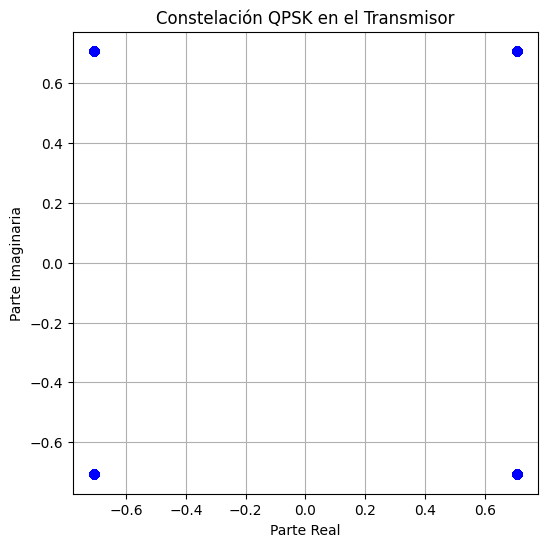

In [27]:
# Visualización de la constelación antes de la transmisión (antes del canal)
plt.figure(figsize=(6,6))
plt.scatter(np.real(symbols), np.imag(symbols), color='blue', alpha=0.5)
plt.title(f'Constelación {modulation_scheme} en el Transmisor')
plt.xlabel('Parte Real')
plt.ylabel('Parte Imaginaria')
plt.grid(True)
plt.axis('equal')
plt.show()

In [28]:
# Simular transmisión sobre un canal AWGN
def simulate_transmission(signal, snr_db):
    """Simula la transmisión sobre un canal AWGN."""
    # Calcular potencia de señal y ruido
    signal_power = np.mean(np.abs(signal)**2)
    snr_linear = 10**(snr_db / 10)
    noise_power = signal_power / snr_linear

    # Generar ruido blanco gaussiano
    noise = np.sqrt(noise_power / 2) * (
        np.random.randn(len(signal)) + 1j * np.random.randn(len(signal))
    )

    # Añadir ruido a la señal
    received_signal = signal + noise
    return received_signal

received_signal = simulate_transmission(signal_complex, snr_db)

# Guardar la señal recibida para el receptor
np.save('../data/received_signal_simulation.npy', received_signal)

print("Simulación de transmisión completa. Señal guardada para el procesamiento del receptor.")


Simulación de transmisión completa. Señal guardada para el procesamiento del receptor.


Preámbulo detectado en el índice: 2


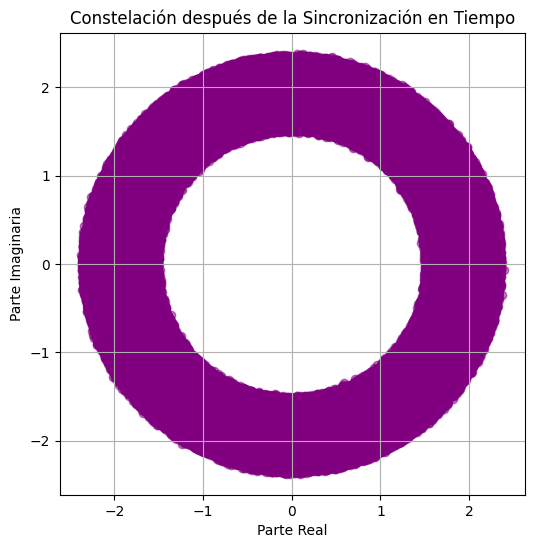

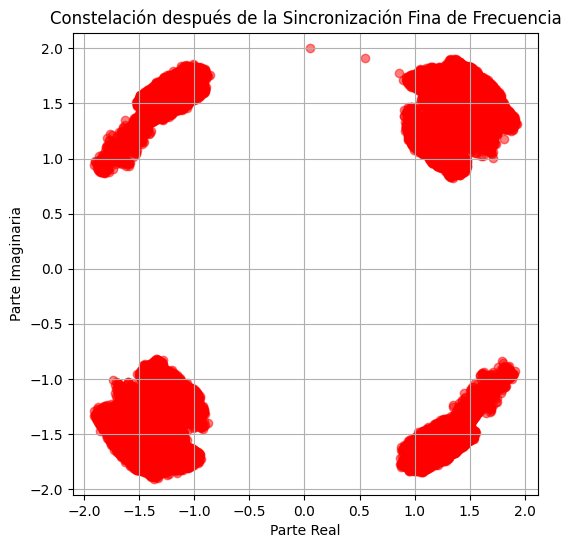

Ancho de imagen: 488, Alto de imagen: 599


In [29]:
# Parámetros del receptor
samples_per_symbol = 8
beta = 0.2
num_taps = 101
sample_rate = samples_per_symbol  # Debe coincidir con el transmisor

# Cargar señal recibida
received_signal = np.load('../data/received_signal_simulation.npy')

# Cargar bits del preámbulo
preamble_bits = np.load('../data/preamble_bits_simulation.npy')
num_padding_bits = (-len(preamble_bits)) % mod_schemes[modulation_scheme]
preamble_bits = np.concatenate((preamble_bits, np.zeros(num_padding_bits, dtype=np.uint8)))
preamble_symbols = bits_to_symbols(preamble_bits, modulation_scheme)

# Filtrado adaptado con filtro RRC
rrc_coef = rrc_filter(beta, samples_per_symbol, num_taps)
matched_filtered_signal = np.convolve(received_signal, rrc_coef, mode='same')

# Sincronización temporal (correlación cruzada con el preámbulo)
symbols_per_preamble = len(preamble_symbols)
preamble_upsampled = np.zeros(len(preamble_symbols) * samples_per_symbol, dtype=complex)
preamble_upsampled[::samples_per_symbol] = preamble_symbols

# Realizar correlación cruzada
correlation = np.correlate(matched_filtered_signal, preamble_upsampled, mode='valid')

# Encontrar el pico de correlación
peak_index = np.argmax(np.abs(correlation))
print(f"Preámbulo detectado en el índice: {peak_index}")

# Extraer la señal sincronizada a partir del pico de correlación
signal_aligned = matched_filtered_signal[peak_index + len(preamble_upsampled):]

# Sincronización de tiempo (Mueller-Muller)
timing_recovered_signal = mueller_muller_timing_recovery(signal_aligned, samples_per_symbol)

# Visualización de la constelación después de la sincronización en tiempo
plt.figure(figsize=(6,6))
plt.scatter(np.real(timing_recovered_signal), np.imag(timing_recovered_signal), color='purple', alpha=0.5)
plt.title('Constelación después de la Sincronización en Tiempo')
plt.xlabel('Parte Real')
plt.ylabel('Parte Imaginaria')
plt.grid(True)
plt.axis('equal')
plt.show()

# Sincronización de fase
modulation_order = {'BPSK':2, 'QPSK':4, '16QAM':16, '64QAM':64}[modulation_scheme]
frequency_corrected_signal = costas_loop(timing_recovered_signal, modulation_order=modulation_order)

# Visualización de la constelación después de la sincronización fina de frecuencia
plt.figure(figsize=(6,6))
plt.scatter(np.real(frequency_corrected_signal), np.imag(frequency_corrected_signal), color='red', alpha=0.5)
plt.title('Constelación después de la Sincronización Fina de Frecuencia')
plt.xlabel('Parte Real')
plt.ylabel('Parte Imaginaria')
plt.grid(True)
plt.axis('equal')
plt.show()

# Demodulación de los símbolos de datos
received_symbols = frequency_corrected_signal

received_bits = symbols_to_bits(received_symbols, modulation_scheme)

# Eliminar bits de padding
num_total_bits = len(encoded_header_bits) + len(encoded_bits)
received_bits = received_bits[:num_total_bits]

# Ahora aplicar la decodificación de canal al resto de los bits
decoded_bits_rest = channel_decode(received_bits, repetition=3)

# Concatenar los bits decodificados
decoded_bits = np.concatenate((decoded_bits_rest,))

# Extraer y decodificar el encabezado
header_bits = decoded_bits[:32]
width_bits = header_bits[:16]
height_bits = header_bits[16:32]

# Convertir bits a bytes
width_bytes = np.packbits(width_bits)
height_bytes = np.packbits(height_bits)

# Convertir bytes a enteros de 16 bits
width = int(np.frombuffer(width_bytes.tobytes(), dtype='>u2')[0])
height = int(np.frombuffer(height_bytes.tobytes(), dtype='>u2')[0])

print(f"Ancho de imagen: {width}, Alto de imagen: {height}")

# Extraer bits de imagen
image_bits = decoded_bits[32:]
# Ajustar longitud
expected_bits = width * height * 3 * 8  # 3 canales (RGB), 8 bits por canal
image_bits = image_bits[:expected_bits]

# Convertir bits a bytes
image_bytes = np.packbits(image_bits)
# Convertir bytes a matriz de imagen
image_array = np.reshape(image_bytes, (height, width, 3))
# Crear y mostrar la imagen
image = Image.fromarray(image_array, 'RGB')
image.show()

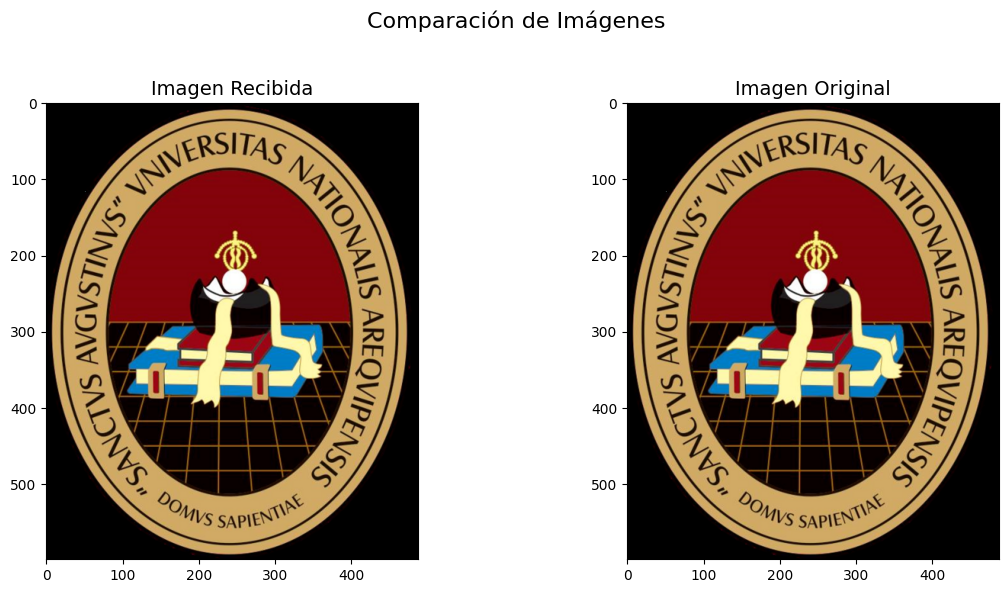

In [30]:
# Mostrar la imagen original y la recibida para comparación usando matplotlib
plt.figure(figsize=(12, 6))
plt.suptitle('Comparación de Imágenes', fontsize=16)

# Imagen recibida
plt.subplot(1, 2, 1)
plt.imshow(image_array)
plt.title('Imagen Recibida', fontsize=14)

# Cargar la imagen original
image_original = Image.open('../images/Escudo_UNSA.png')
image_original = image_original.convert('RGB')
plt.subplot(1, 2, 2)
plt.imshow(image_original)
plt.title('Imagen Original', fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajustar diseño y dejar espacio para el título
plt.show()